<a href="https://colab.research.google.com/github/nataliagdorado/MachineLearningMenstrualIrregularities/blob/main/2_Experimental_design_and_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. EXPERIMENTAL DESIGN
The code implemented was following the tutorial of scikit-learn: https://scikit-learn.org/stable/modules/cross_validation.html

## 1.1. Data loading and inspection
We import the necessary libraries and load the dataset using the Pandas read_csv function. We specified the semicolon separator` (;)` to ensure correct parsing of the raw file. After that, we performed a preliminary inspection of the data structure `(.head())` and verified variable types and non-null counts `(.info())` to validate data integrity.


In [13]:
from google.colab import files
import pandas as pd

# 1 Upload file
print("Upload the dataset (CSV):")
uploaded = files.upload()

# 2 Load into DataFrame
filename = list(uploaded.keys())[0]
print(f"File detected: {filename}")
df = pd.read_csv(filename, sep=';')

# 3 Initial Inspection
print("Dataset Shape:", df.shape)
display(df.head())
print("\nVariable Types Info:")
df.info()


Upload the dataset (CSV):


Saving MentrualSetFinalCSV.csv to MentrualSetFinalCSV (2).csv
File detected: MentrualSetFinalCSV (2).csv
Dataset Shape: (10000, 17)


,avg_bleeding_days,Oligomenorrhea,Polymenorrhea,Menorrhagia,Amenorrhea,age,bmi,tracking_duration_months,pain_score,avg_cycle_length,cycle_length_variation,bleeding_volume_score,intermenstrual_episodes,cycle_variation_coeff,pattern_disruption_score,life_stage,duration_abnormality_flag
0,5,1.0,0.0,0.0,0.0,51,19.4,22,2,27.783958,59.154302,2,1,0.000000,20.000000,perimenopausal,0
1,4,1.0,0.0,0.0,0.0,41,22.4,15,0,27.783958,26.434149,2,0,48.610705,10.000000,reproductive,0
2,4,1.0,0.0,0.0,0.0,27,27.0,12,1,38.211179,39.886876,2,0,103.660141,92.928112,reproductive,0
3,4,0.0,1.0,0.0,0.0,20,22.4,14,1,27.783958,23.175502,2,0,121.021249,100.000000,reproductive,0
4,4,0.0,0.0,0.0,1.0,33,22.8,11,3,27.783958,0.000000,2,0,0.000000,10.000000,reproductive,1



Variable Types Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   avg_bleeding_days          10000 non-null  int64  
 1   Oligomenorrhea             10000 non-null  float64
 2   Polymenorrhea              10000 non-null  float64
 3   Menorrhagia                10000 non-null  float64
 4   Amenorrhea                 10000 non-null  float64
 5   age                        10000 non-null  int64  
 6   bmi                        10000 non-null  float64
 7   tracking_duration_months   10000 non-null  int64  
 8   pain_score                 10000 non-null  int64  
 9   avg_cycle_length           10000 non-null  float64
 10  cycle_length_variation     10000 non-null  float64
 11  bleeding_volume_score      10000 non-null  int64  
 12  intermenstrual_episodes    10000 non-null  int64  
 13  cycle_variation_coeff    

## 1.2. Preprocessing and defining the target
The column `life_stage` is object type, but Python models doesn't understand the text, only numbers. So we convert that attribute.
In the last lines we define the target from the rest of variables

In [14]:
from sklearn.preprocessing import LabelEncoder
# 1 Convert life_stage to numbers and remove the original text-column
le = LabelEncoder()
df['life_stage_encoded'] = le.fit_transform(df['life_stage'])
df_model = df.drop('life_stage', axis=1)
print(f"   - 'life_stage' encoded mappings: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 2 Defining Features (X) and Target (y)
y = df_model['duration_abnormality_flag']
X = df_model.drop('duration_abnormality_flag', axis=1)
print(f"   - Features Matrix (X) shape: {X.shape}")
print(f"   - Target Vector (y) shape: {y.shape}")

   - 'life_stage' encoded mappings: {'adolescent': np.int64(0), 'perimenopausal': np.int64(1), 'reproductive': np.int64(2)}
   - Features Matrix (X) shape: (10000, 16)
   - Target Vector (y) shape: (10000,)


About the prints, the first one "   - 'life_stage' encoded mappings: `{'adolescent': np.int64(0), 'perimenopausal': np.int64(1), 'reproductive': np.int64(2)}`" means that the integers are now 0, 1 and 2 for life_stage. And the second print confirm the dimension of the xplot: the feature matrix, X, have 10.000 samples with 16 variables. And the target vector, y, has 10.000 class labels.

## 1.3. Experimental setup
To evaluate model performance in a medical context, we defined a custom Cost Matrix. We prioritized sensitivity by assigning a penalty of 10 to False Negatives (missing an anomaly), compared to a penalty of 1 for False Positives. We use a 10-fold stratified cross-validation strategy.

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix
# 1 Defining the Cost Matrix
# FP = 1 (False Alarm) FN = 10 (Missed Diagnosis)
def cost_loss_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost_fp = 1
    cost_fn = 10
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost

# We create a custom scorer for Scikit-Learn (greater_is_better=False because it's a cost)
cost_scorer = make_scorer(cost_loss_func, greater_is_better=False)

# 2 Defining Validation Method
# 10 Fold Stratified Cross-Validation
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("   - Cost Matrix: False Positive=1, False Negative=10. 10-Fold Stratified Cross-Validation")


   - Cost Matrix: False Positive=1, False Negative=10. 10-Fold Stratified Cross-Validation


# 2. MODEL TRAINING
AQUÍ BREVE EXPLICACIÓN

## 2.1. Parte Sarah


## 2.3. Parte Abril

## 2.6. Neural Networks
Following the GitHub codes [4_PredictiveModels](https://github.com/AbrahamOtero/MLiB/blob/main/4_PredictiveModels.ipynb) and [5_IssuesTrainingNetworks](https://github.com/AbrahamOtero/MLiB/blob/main/4.5_IssuesTrainingNeuralNetworks.ipynb) we're going to apply the neural network model. We do a layer evolution to find the optimal balance between complexity and generalization.

### 2.6.0. Standard Neural Network (Baseline)
Following Notebook 4

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb

### 2.6.1. Two hidden layers. Deep learning with Keras.
Following GitHub 5_DeepLearning, we studied Deep Learning approach using the Keras/TensorFlow library. For the model's convergence, we made the following decisions:


*   For the hidden layers: We selected ReLU (Rectified Linear Unit) function. Is computationally efficcient and helps to decrease the "vanishing gradient".
*   For the output layer, we used the sigmoid function. Since our target is binary (`duration_abnormality_flag`), Sigmoid is the standard.
* We used adam eith default parameters instead the others proposed in the Notebook 5 (sgd and rmsprop) because it can automatically adjust the learning rate during training.
* Loss function: We minimized `binary_crossentroply`

> Añadir blockquote









In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# 1 Scaling Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2 Architecture
model_1 = Sequential([
    Dense(32, activation='relu', input_shape=(X_scaled.shape[1],)), # Layer 1
    Dense(16, activation='relu'),                                   # Layer 2
    Dense(1, activation='sigmoid')                                  # Output
])

# 3 Compile
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4 Train with Cost Matrix (1 vs 10)
weights = {0: 1, 1: 10}
history_1 = model_1.fit(X_scaled, y, epochs=40, batch_size=32, class_weight=weights, verbose=0)

# 5 Results
acc_1 = history_1.history['accuracy'][-1] * 100
print(f"Result (accuracy)): {acc_1:.2f}%")
print("   - Observation: Check if this accuracy is good enough or if we need more power.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Result (accuracy)): 97.33%
   - Observation: Check if this accuracy is good enough or if we need more power.


The print says: `Result (accuracy)): 97.28%` what is quite good

### 2.6.2. Three hidden layers + Dropout

In [18]:
from tensorflow.keras.layers import Dropout
# 1 Architecture (Deeper + Regularization)
model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),

    # DROPOUT: We turn off the 0.3 of the neurons to avoid overfitting
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 2 Compile
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3 Train with Cost Matrix
weights = {0: 1, 1: 10}
history_2 = model_2.fit(X_scaled, y, epochs=50, batch_size=32, class_weight=weights, verbose=0)

# 4 Results
acc_2 = history_2.history['accuracy'][-1] * 100
print(f"Result Exp 2 (Accuracy): {acc_2:.2f}%")
print("   - Observation: Comparing this with last section. Dropout makes the model more robust.")


Result Exp 2 (Accuracy): 96.69%
   - Observation: Comparing this with last section. Dropout makes the model more robust.


The accuracy here is` Result Exp 2 (Accuracy): 96.71%`. Even with the dropout the model is capable of detect abnormalities. The dataset has clear patterns and the model is powerful.


### Visualizing the Data Flow
Unlike the simplified node-link diagrams generated by Altair AI Studio, we utilized Keras structural plots. The code was following [TensorFlow Keras tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model)

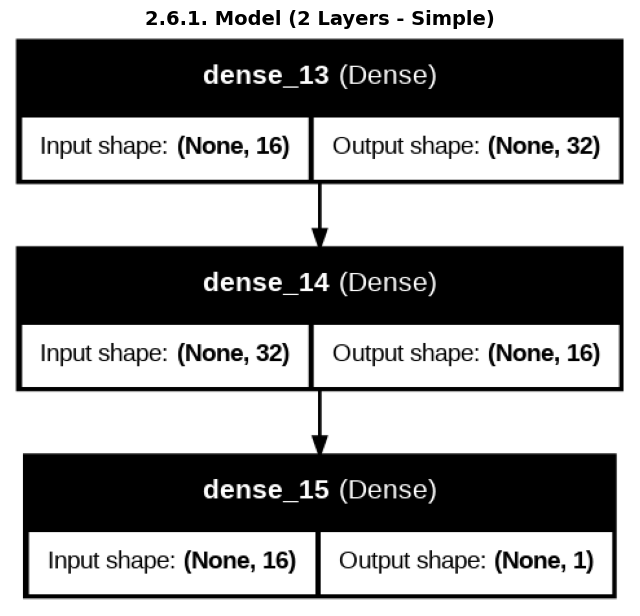

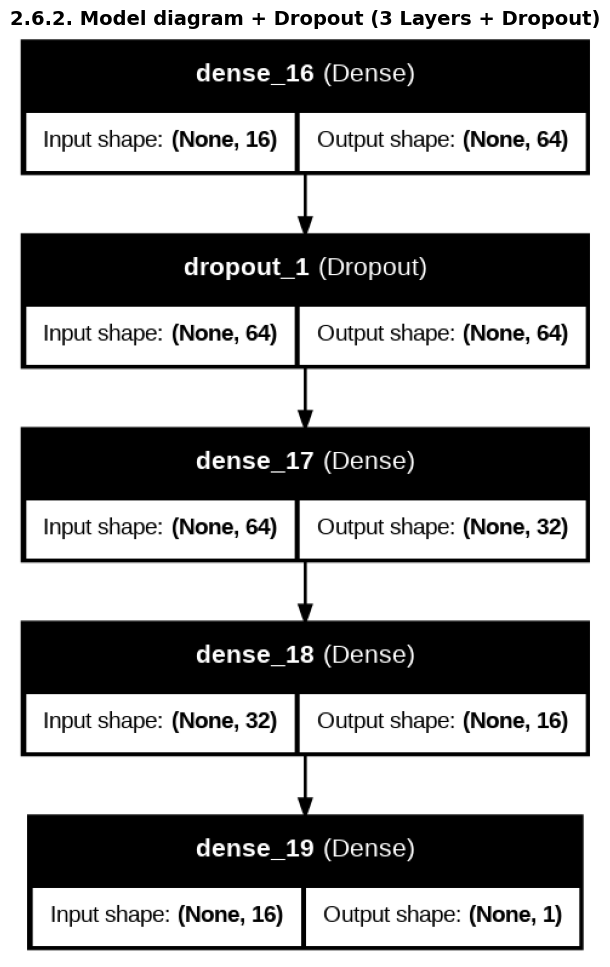

In [24]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os

# Auxiliar function
def mostrar_imagen(ruta, titulo):
    img = plt.imread(ruta)
    plt.figure(figsize=(8, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title(titulo, fontsize=14, fontweight='bold')
    plt.show()

# MODEL 1
fichero1 = 'diagrama_modelo1_shallow.png'
plot_model(model_1,
           to_file=fichero1,
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB', dpi=96)
mostrar_imagen(fichero1, "2.6.1. Model (2 Layers - Simple)")

# MODEL 2
fichero2 = 'diagrama_modelo2_deep_dropout.png'
plot_model(model_2,
           to_file=fichero2,
           show_shapes=True,
           show_layer_names=True,
           # It shows Dropout box
           rankdir='TB', dpi=96)
mostrar_imagen(fichero2, "2.6.2. Model diagram + Dropout (3 Layers + Dropout)")
